## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Clustering

In [2]:
def advanced_mood_clustering(df):
    def get_mood_cluster(row):
        # Passionate, Rousing, Confident, Boisterous, Rowdy (Cluster 1)
        if (row['energy'] > 0.75 and 
            row['valence'] > 0.6 and 
            row['tempo'] > 130 and 
            row['loudness'] > -3):
            return "passionate"
        
        # Rollicking, Cheerful, Fun, Sweet, Amiable (Cluster 2)
        elif (row['energy'] > 0.6 and 
              row['valence'] > 0.5 and 
              row['danceability'] > 0.6 and 
              row['tempo'] > 110):
            return "cheerful"
        
        # Literate, Poignant, Wistful, Bittersweet, Autumnal, Brooding (Cluster 3)
        elif (row['energy'] < 0.4 and 
              row['valence'] < 0.4 and 
              row['acousticness'] > 0.5 and 
              row['tempo'] < 100):
            return "melancholic"
        
        # Humorous, Silly, Campy, Quirky, Whimsical, Witty, Wry (Cluster 4)
        elif (row['danceability'] > 0.5 and 
              row['valence'] > 0.5 and 
              row['energy'] < 0.5):
            return "playful"
        
        # Fallback to neutral
        return "neutral"

    # Apply advanced clustering
    df['mood_cluster'] = df.apply(get_mood_cluster, axis=1)
    return df

## Numeric Data Preprocessing

In [3]:
def preprocess_advanced(csv_path):
    """
    Enhanced data preprocessing with more robust feature engineering
    """
    # Load data
    df = pd.read_csv(csv_path)
    
    # Clean numeric columns
    numeric_columns = [
        "danceability", "energy", "valence", "tempo", 
        "acousticness", "loudness", "liveness"
    ]
    
    # Handle missing values and convert to numeric
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())
    
    # Advanced mood clustering
    df = advanced_mood_clustering(df)
    
    # Feature scaling with StandardScaler for better model performance
    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    
    # Encode mood clusters
    label_encoder = LabelEncoder()
    df['mood_encoded'] = label_encoder.fit_transform(df['mood_cluster'])
    
    return df, numeric_columns, label_encoder

## Text Preprocessing

In [4]:
def advanced_text_preprocessing(df, max_vocab=15000, max_len=250):
    """
    Improved text preprocessing with TF-IDF and Tokenization
    """
    # Ensure lyrics are cleaned
    lyrics = df['lyrics'].fillna('').astype(str)
    
    # TF-IDF Vectorization for capturing text importance
    tfidf = TfidfVectorizer(max_features=max_vocab)
    text_features = tfidf.fit_transform(lyrics).toarray()
    
    # Tokenization as fallback/supplement
    tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
    tokenizer.fit_on_texts(lyrics)
    sequences = tokenizer.texts_to_sequences(lyrics)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, truncating='post')
    
    return text_features, padded_sequences, tokenizer

## Building the Model (Neural-Network)

In [5]:
def build_advanced_model(num_features, text_vocab_size, text_max_len, num_classes):
    # Numerical input path
    num_input = Input(shape=(num_features,), name='numeric_input')
    x_num = Dense(128, activation='relu')(num_input)
    x_num = Dropout(0.4)(x_num)
    x_num = Dense(64, activation='relu')(x_num)
    
    # Text input path with improved LSTM and pooling
    text_input = Input(shape=(text_max_len,), name='text_input')
    x_text = Embedding(input_dim=text_vocab_size, output_dim=100)(text_input)
    x_text = LSTM(160, return_sequences=True)(x_text)
    x_text = GlobalAveragePooling1D()(x_text)
    x_text = Dropout(0.4)(x_text)
    
    # Combine inputs with more complex interaction
    combined = concatenate([x_num, x_text])
    x = Dense(96, activation='relu')(combined)
    x = Dropout(0.5)(x)
    x = Dense(48, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[num_input, text_input], outputs=output)
    model.compile(
        optimizer='adam', 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

# Main Function

Epoch 1/75
305/305 ━━━━━━━━━━━━━━━━━━━━ 77s 243ms/step - accuracy: 0.8000 - loss: 0.6226 - val_accuracy: 0.9795 - val_loss: 0.0671 - learning_rate: 0.0010
Epoch 2/75
305/305 ━━━━━━━━━━━━━━━━━━━━ 74s 243ms/step - accuracy: 0.9784 - loss: 0.0782 - val_accuracy: 0.9887 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 3/75
305/305 ━━━━━━━━━━━━━━━━━━━━ 74s 242ms/step - accuracy: 0.9883 - loss: 0.0392 - val_accuracy: 0.9922 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 4/75
305/305 ━━━━━━━━━━━━━━━━━━━━ 76s 248ms/step - accuracy: 0.9899 - loss: 0.0301 - val_accuracy: 0.9924 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 5/75
305/305 ━━━━━━━━━━━━━━━━━━━━ 72s 238ms/step - accuracy: 0.9923 - loss: 0.0213 - val_accuracy: 0.9920 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 6/75
305/305 ━━━━━━━━━━━━━━━━━━━━ 72s 237ms/step - accuracy: 0.9938 - loss: 0.0184 - val_accuracy: 0.9947 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 7/75
305/305 ━━━━━━━━━━━━━━━━━━━━ 74s 242ms/step - accuracy: 0.9

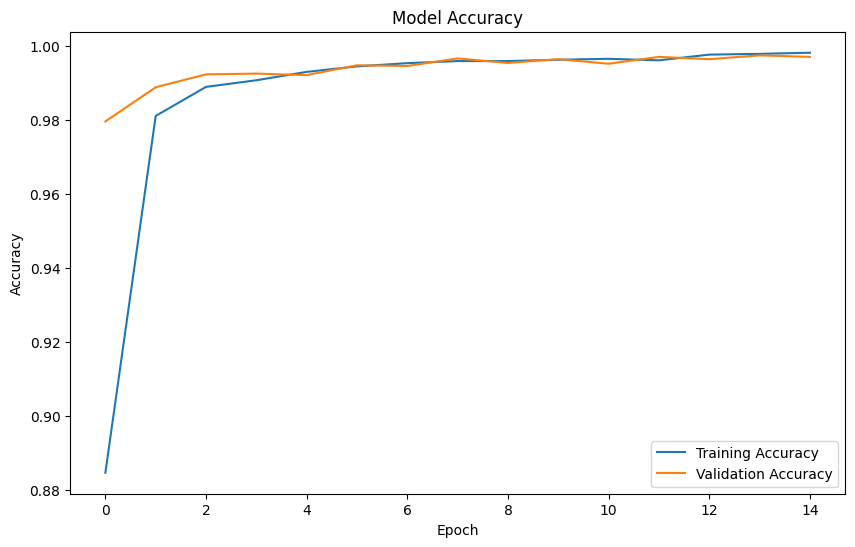

In [6]:
def main():
    csv_path = "songs_data_with_lyrics.csv"
    
    # Preprocess data
    df, numeric_features, label_encoder = preprocess_advanced(csv_path)
    
    # Advanced text features
    text_features, text_sequences, tokenizer = advanced_text_preprocessing(df)
    
    # Numerical features
    numerical_features = df[numeric_features].values
    y = df['mood_encoded'].values
    
    # Stratified train-test split
    X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
        text_sequences, numerical_features, y, 
        test_size=0.2, random_state=42, stratify=y
    )
    
    # Build and train model
    model = build_advanced_model(
        num_features=len(numeric_features),
        text_vocab_size=len(tokenizer.word_index) + 1,
        text_max_len=250,
        num_classes=len(label_encoder.classes_)
    )
    
    # Training callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=7, 
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=4, 
        min_lr=0.00001
    )
    
    # Train model
    history = model.fit(
        [X_num_train, X_text_train], y_train,
        validation_data=([X_num_test, X_text_test], y_test),
        epochs=75,  # Increased for more learning
        batch_size=64,  # Slightly larger batch size
        callbacks=[early_stopping, reduce_lr]
    )
    
    # Evaluate model
    y_pred = model.predict([X_num_test, X_text_test]).argmax(axis=1)
    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred, 
        target_names=label_encoder.classes_
    ))
    
    # Visualization
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()